In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_events_wdict
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

#### Load excel sheet with metadata for experiments

In [5]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [62]:
plotdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\brain_states_analyses\EP metrics'

### Load subjects .csv

In [7]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects_2024_05.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

In [34]:
subject_df.head()

,exp_type,mouse,experiment,sweep_states,stim_depth,bad_chs,analyze,data_loc,CCF_res,notes
19,psilocybin,703064,aw_psi_2023-11-30_12-06-43,"awake,psilocybin",deep,3,True,F:\psi_exp\mouse703064\aw_psi_2023-11-30_12-06...,25,NaN
20,urethane,703064,urethane_2023-12-01_11-20-15,urethane,deep,"0,3",True,F:\psi_exp\mouse703064\urethane_2023-12-01_11-...,25,NaN
21,isoflurane,709401,aw_iso_2023-12-13_09-55-07,"awake,isoflurane",deep,3,True,F:\psi_exp\mouse709401\aw_iso_2023-12-13_09-55...,25,NaN
22,psilocybin,709401,aw_psi_2023-12-14_11-17-30,"awake,psilocybin",deep,3,True,F:\psi_exp\mouse709401\aw_psi_2023-12-14_11-17...,25,NaN
23,urethane,709401,urethane_2023-12-15_11-03-00,urethane,deep,3,True,F:\psi_exp\mouse709401\urethane_2023-12-15_11-...,25,evoked responses are suspect


### Multi-subject loop

#### Get EEG traces for all states/estim

In [19]:
StimType = 'biphasic'

In [29]:
allsubs = np.unique(subject_df.mouse.values)

all_info = {}
for mousei in allsubs:
    print(mousei)
    mouse_df = subject_df[subject_df['mouse'] == mousei]
    
    if not any(mouse_df.analyze.values):
        print(' Not analyzing the experiments for this subject./n')
        continue
        
    all_info[mousei] = {}

    for dfind, subrow in mouse_df.iterrows():
        print(' {}'.format(subrow.experiment))
        if not subrow.analyze:
            print('  Not analyzing this experiment.')
            continue
        all_info[mousei][subrow.exp_type] = {'info': {}, 'EEG_traces': {}}
        subexp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)

        ## Grab exp metadata from Templeton-log_exp ##
        exp_meta = metadata[(
            (metadata['mouse_name'].str.contains(subrow.mouse)) &
            (metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()

        ## Get injection times ##
        if subrow.exp_type in ['psilocybin', 'ketanserin']:
            inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        else:
            print('  This {} experiment has no injection times.'.format(subrow.exp_type))
            inj_times = None

        ## Load stim log and apply sweep labels ##
        stim_log = pd.read_csv(subexp.stimulus_log_file).astype({'parameter': str})
        ### Get state label for each sweep ###
        all_sweeps = np.unique(stim_log['sweep'].values)
        sweep_state_list = []
        for char in subrow.sweep_states.split(','):
            sweep_state_list.append(char)
        if len(sweep_state_list) == 1:
            sweep_state_list = sweep_state_list * len(all_sweeps)
        stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
        ### Get list of states and the middle current ###
        states = np.unique(stim_log['state'].values)
        currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
        if len(currents) > 1:
            estim_current = {x: str(y) for x, y in zip(['low', 'mid', 'high'], currents)}
        else:
            estim_current = {'mid': str(currents[0])}

        ## Get bad EEG channels ##
        badchstr = subrow.bad_chs.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))

        ## Load EEG traces ##
        all_EEG_traces = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces.npy'))
        EEG_event_timestamps = np.load(os.path.join(subexp.data_folder, 'evoked_data', 'event_EEGtraces_times.npy'))
        eeg_chs = np.arange(0, all_EEG_traces.shape[1])
        GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])
        all_info[mousei][subrow.exp_type]['info']['good_chs'] = GOOD_CHS
#         all_info[mousei][subrow.exp_type]['info']['trial_count'] = {}
#         all_info[mousei][subrow.exp_type]['info']['rest_trials'] = {}
#         all_info[mousei][subrow.exp_type]['info']['good_trials'] = {}

        ## Get event traces ##
        estimlog = stim_log[stim_log['stim_type'] == StimType]
        for statei in states:
            all_info[mousei][subrow.exp_type]['EEG_traces'][statei] = {}
#             all_info[mousei][subrow.exp_type]['info']['trial_count'][statei] = {}
#             all_info[mousei][subrow.exp_type]['info']['rest_trials'][statei] = {}
#             all_info[mousei][subrow.exp_type]['info']['good_trials'][statei] = {}

            for clevel, parami in estim_current.items():
#                 event_inds = get_events_wdict(estimlog, {'state': statei, 'parameter': parami}, out='index')
                event_inds = get_events_wdict(
                    estimlog, {'state': statei, 'parameter': parami, 'good': True, 'resting_trial': True}, out='index')
                if len(event_inds) == 0:
                    continue
                event_traces = all_EEG_traces[:, :, event_inds]
                ## Apply common average reference ##
                event_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]
                all_info[mousei][subrow.exp_type]['EEG_traces'][statei][clevel] = [EEG_event_timestamps, event_traces]
#                 all_info[mousei][subrow.exp_type]['info']['trial_count'][statei][clevel] = len(event_inds)
#                 all_info[mousei][subrow.exp_type]['info']['rest_trials'][statei][clevel] = stim_log.resting_trial.values[event_inds]
#                 all_info[mousei][subrow.exp_type]['info']['good_trials'][statei][clevel] = stim_log.good.values[event_inds]

    print('')

676727
 aw_psi_2023-05-10_09-49-12
Experiment type: electrical and sensory stimulation
 aw_iso_2023-05-11_09-44-46
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 urethane_2023-05-12_11-35-38
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

689239
 aw_iso_2023-08-09_11-15-42
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 aw_psi_2023-08-10_11-26-36
  Not analyzing this experiment.
 urethane_2023-08-11_11-33-46
Experiment type: electrical and sensory stimulation
  This urethane experiment has no injection times.

689242
 aw_psi_2023-07-19_10-29-49
Experiment type: electrical and sensory stimulation
 aw_iso_2023-07-20_10-52-57
Experiment type: electrical and sensory stimulation
  This isoflurane experiment has no injection times.
 urethane_2023-07-21_12-32-25
Experiment type: electrical and sensory stimulation
  This ur

#### Plot some EPs

In [39]:
expdict['EEG_traces']['awake'].keys()

dict_keys(['high'])

<IPython.core.display.Javascript object>


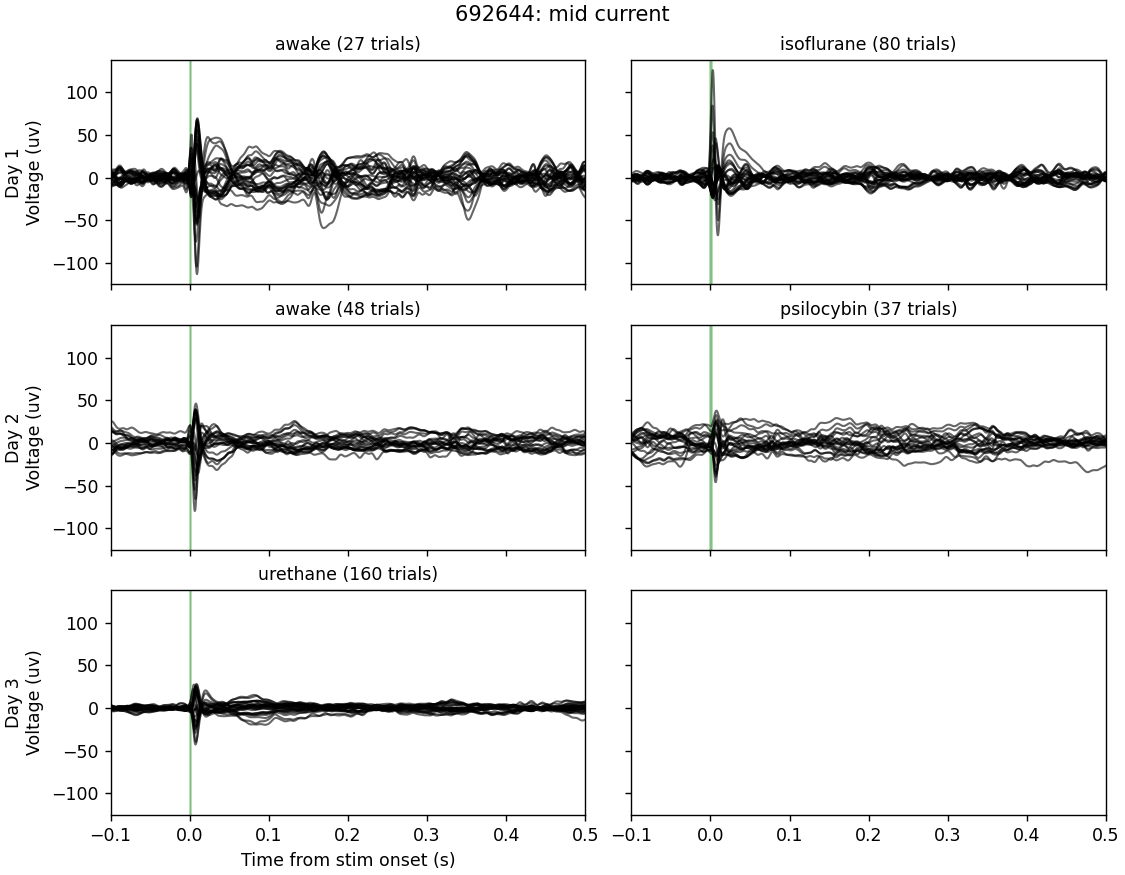

In [61]:
subsub = '692644'
pcurr = 'mid'
plot_window = [-0.1, 0.5]

exp_num = len(all_info[subsub])
fig, axs = plt.subplots(exp_num, 2, figsize=(9, 7), constrained_layout=True, sharex=True, sharey=True)

for rowi, (expday, expdict) in enumerate(all_info[subsub].items()):
    good_chs = expdict['info']['good_chs']
    for coli, (statei, stdict) in enumerate(expdict['EEG_traces'].items()):
        if pcurr not in stdict.keys():
            continue
        timex = stdict[pcurr][0]
        ep = np.mean(stdict[pcurr][1], axis=2)

        axs[rowi,coli].axvspan(0, 0.002, color='g', alpha=0.3)
        axs[rowi,coli].plot(timex, ep[:, good_chs], 'k', linewidth=1.2, alpha=0.6)
        axs[rowi,coli].set_title('{} ({:d} trials)'.format(statei, stdict[pcurr][1].shape[2]))
        
        if coli == 0:
            axs[rowi,coli].set_ylabel('Day {:d}\nVoltage (uv)'.format(rowi+1))

        
axs[rowi,coli].set_xlim(plot_window)
axs[rowi,coli].set_xlabel('Time from stim onset (s)')

fig.suptitle('{}: {} current'.format(subsub, pcurr))

## Save ##
figname = '{}_{}_EPs_goodresttrials.png'.format(subsub, pcurr)
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

# EP metrics

In [54]:
PCI_params = {
    'baseline_window': (-0.8, -0.002), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.002, 0.8), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}
zlim = 3
trial_lim = 5

In [55]:
EEG_sample_rate = 2500.

all_sub_metrics = []
for mousei in all_info.keys():
    print(mousei)
    for expi in all_info[mousei].keys():
        print(' {}'.format(expi))
        good_chs = all_info[mousei][expi]['info']['good_chs']
        for statei in all_info[mousei][expi]['EEG_traces'].keys():
            print('  {}'.format(statei))
            for curri in all_info[mousei][expi]['EEG_traces'][statei].keys():
                
                timex = all_info[mousei][expi]['EEG_traces'][statei][curri][0]
                ep_trials = all_info[mousei][expi]['EEG_traces'][statei][curri][1]
                
                num_trials = ep_trials.shape[2]
                
                if num_trials >= trial_lim:
                    state_avg = np.mean(ep_trials, axis=2)
                    
                    ## Calculate global field power duration ##
                    gfpow = np.std(state_avg[:, good_chs], axis=1)
                    blmean = np.mean(gfpow[timex < 0])
                    blstd = np.std(gfpow[timex < 0])
                    zgfpow = (gfpow - blmean) / blstd
                    response_duration = np.sum(zgfpow[timex > 0] > zlim) / EEG_sample_rate
                    
                    ## Area under global field power curve ##
                    zerp = np.where((zgfpow[timex > 0] - zlim) >= 0, (zgfpow[timex > 0] - zlim), 0.)
                    auc = integrate.simps(zerp, timex[timex > 0], axis=0, even='last')
                    
                    ## Calulate PCIst ##
                    PCIval = calc_PCIst(state_avg[:, good_chs].T, timex, **PCI_params)
                    
                    
                    all_sub_metrics.append([
                        mousei, expi, len(good_chs), statei, curri, num_trials, response_duration, auc, PCIval
                    ])
                    
    print('')
    
EEG_metrics = pd.DataFrame(
    all_sub_metrics,
    columns=['mouse', 'experiment', 'num_good_chs', 'state', 'stim_current', 'num_trials', 'response_duration', 'response_magnitude', 'PCIst']
)

676727
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689239
 isoflurane
  awake
  isoflurane
 urethane
  urethane

689242
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

692644
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane

703064
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane

703065
 psilocybin
  awake
  psilocybin
 isoflurane
  awake
  isoflurane
 urethane
  urethane

709401
 isoflurane
  awake
  isoflurane
 psilocybin
  awake
  psilocybin
 urethane
  urethane



<IPython.core.display.Javascript object>


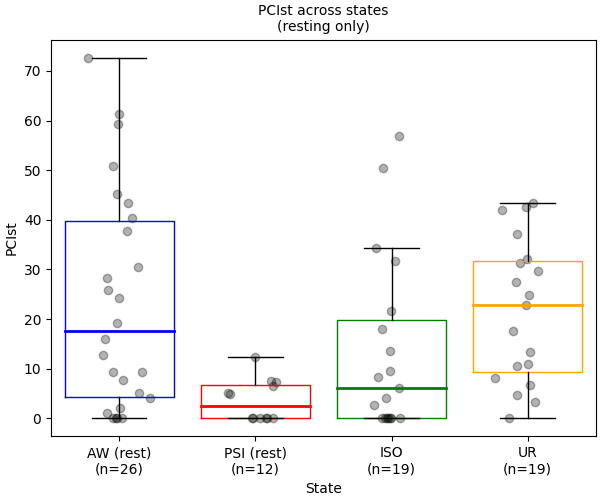

In [66]:
pmetric = 'PCIst' # 'PCIst' 'response_magnitude' 'response_duration'
pstates = ['awake', 'psilocybin', 'isoflurane', 'urethane']

st_labels = ['AW (rest)', 'PSI (rest)', 'ISO', 'UR']
st_colors = ['blue', 'red', 'green', 'orange']

fig, ax = plt.subplots(figsize=(6,5), constrained_layout=True)
xlabels = []
for ii, statei in enumerate(pstates):
    statedf = EEG_metrics[EEG_metrics['state'] == statei]
    xs = np.random.normal(ii, 0.1, len(statedf)) # np.zeros(len(statedf)) + ii
    ax.boxplot(
        statedf[pmetric].values, positions=[ii], widths=[0.8], showfliers=False,
        medianprops={'color': st_colors[ii], 'linewidth': 2}, boxprops={'color': st_colors[ii]}
    )
    ax.scatter(xs, statedf[pmetric].values, c='k', marker='o', alpha=0.3)
    xlabels.append('{}\n(n={:d})'.format(st_labels[ii], len(statedf)))
        
ax.set_xticklabels(xlabels)
ax.set_xlabel('State')
ax.set_ylabel(pmetric)
ax.set_title('{} across states\n(resting only)'.format(pmetric))

## Save ##
figname = '{}_allstates_{}.png'.format(pmetric, date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [57]:
statedf = EEG_metrics[EEG_metrics['state'] == 'psilocybin']

In [58]:
statedf

,mouse,experiment,num_good_chs,state,stim_current,num_trials,response_duration,response_magnitude,PCIst
31,692644,psilocybin,21,psilocybin,low,34,0.5656,0.605372,7.282105
32,692644,psilocybin,21,psilocybin,mid,37,0.9216,3.381605,4.865764
33,692644,psilocybin,21,psilocybin,high,28,0.0640,0.028475,0.000000
46,703064,psilocybin,29,psilocybin,low,24,0.0000,0.000000,0.000000
47,703064,psilocybin,29,psilocybin,mid,22,0.0152,0.012438,0.000000
48,703064,psilocybin,29,psilocybin,high,30,0.9564,2.306298,6.555489
52,703065,psilocybin,27,psilocybin,low,8,0.0076,0.000763,0.000000
53,703065,psilocybin,27,psilocybin,mid,7,0.1256,0.137785,12.404511
54,703065,psilocybin,27,psilocybin,high,7,0.0592,0.056689,0.000000
70,709401,psilocybin,29,psilocybin,low,22,0.0012,0.000014,5.002807


# Testing noise sources

### Plot individual trials; all trials, one ch (resting/running)

### Plot individual trials; all trials, one ch (good/bad)

### Plot individual trials; one trial, all chs

### Calculating ERP metrics

In [27]:
subject = '666194'
day = 'saline'
stim = 'biphasic'
zlim = 3

good_chs = subjects_data[subject][day]['good_chs']
EEG_sample_rate = subjects_data[subject][day]['exp'].ephys_params['EEG']['sample_rate']

for curri, sweepdict in subjects_data[subject][day]['EEG_traces'][stim].items():
    sweep_info = subjects_data[subject][day]['sweep_info_df'][
        (subjects_data[subject][day]['sweep_info_df']['stim'] == stim) &
        (subjects_data[subject][day]['sweep_info_df']['parameter'] == curri)
    ].copy()
    sweep_metrics = []
    for sweepi, trialdict in sweepdict.items():
        trial_type_info = [sweepi]
        collabels = ['sweep']
        for trialtype, datai in trialdict.items():
            collabels.extend([trialtype + '_trial_count', trialtype + '_duration', trialtype + '_magnitude'])
            num_trials = datai[1].shape[2]
            EEG_time = datai[0]
            EEG_traces = datai[1]
            trial_type_info.append(num_trials)
            if num_trials == 0:
                print('*sweep {:d}: no {} trials*'.format(sweepi, trialtype))
                trial_type_info.extend([np.nan, np.nan])
                continue

            state_traces = np.mean(EEG_traces, axis=2)
            ## Calculate global field power duration ##
            gfpow = np.std(state_traces[:, good_chs], axis=1)
            blmean = np.mean(gfpow[EEG_time < 0])
            blstd = np.std(gfpow[EEG_time < 0])
            zgfpow = (gfpow - blmean) / blstd
            response_duration = np.sum(zgfpow[EEG_time > 0] > zlim) / EEG_sample_rate
            ## Area under global field power curve ##
            zerp = np.where((zgfpow[EEG_time > 0] - zlim) >= 0, (zgfpow[EEG_time > 0] - zlim), 0.)
            auc = integrate.simps(zerp, EEG_time[EEG_time > 0], axis=0, even='last')
            trial_type_info.extend([response_duration, auc])
        sweep_metrics.append(trial_type_info)
    sweep_metrics_df = sweep_info.merge(pd.DataFrame(sweep_metrics, columns=collabels), on='sweep', how='left')

*sweep 1: no resting trials*
*sweep 9: no resting trials*


In [28]:
sweep_metrics_df.head()

,stim,parameter,sweep,sweep_onset,sweep_offset,sweep_time,all_trial_count,all_duration,all_magnitude,resting_trial_count,resting_duration,resting_magnitude,running_trial_count,running_duration,running_magnitude
0,biphasic,40,0,1237.13552,1708.90544,1472.922839,120,0.3864,6.566660,7,0.4692,3.037979,113,0.3488,5.952705
1,biphasic,40,1,2040.76826,2512.53861,2276.555779,120,0.4284,7.720646,0,NaN,NaN,120,0.4284,7.720646
2,biphasic,40,2,2802.29727,3274.06774,3038.084872,120,0.3364,4.854573,10,0.1312,0.479728,110,0.3656,5.321663
3,biphasic,40,3,3631.66392,4103.43434,3865.928553,119,0.2732,4.251281,3,0.1176,0.169967,116,0.2672,3.975655
4,biphasic,40,4,4425.39026,4897.16064,4661.177814,120,0.2612,2.461473,13,0.3464,1.673742,107,0.1868,1.970941


<IPython.core.display.Javascript object>


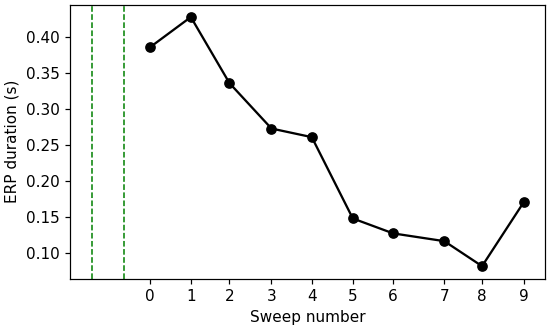

Text(0, 0.5, 'ERP duration (s)')

In [29]:
fig, ax = plt.subplots(figsize=(5, 3), constrained_layout=True)
for inji in subjects_data[subject][day]['inj_times']:
    ax.axvline(inji, color='g', linewidth=1.0, linestyle='dashed')
ax.plot(sweep_metrics_df['sweep_time'].values, sweep_metrics_df['all_duration'].values, color='k', marker='o')
ax.set_xticks(sweep_metrics_df['sweep_time'].values)
ax.set_xticklabels(sweep_metrics_df['sweep'].values)
ax.set_xlabel('Sweep number')
ax.set_ylabel('ERP duration (s)')